Step 1: Mount Google Drive


In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Step 2: Define WSI path


In [4]:
wsi_path = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif"

print(wsi_path)


/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif


Step 3: Install OpenSlide and open the WSI file



In [5]:
# Install OpenSlide system dependencies and Python bindings
!apt-get update
!apt-get install -y openslide-tools
!pip install openslide-python

# Import and open WSI
import openslide

slide = openslide.OpenSlide(wsi_path)

print("WSI opened successfully")
print("Number of levels:", slide.level_count)
print("Level 0 dimensions:", slide.level_dimensions[0])


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 3,917 B in 1s (4,000 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

Step 4: Extract a single reference patch from the WSI


Patch shape: (512, 512, 3)
Patch dtype: uint8


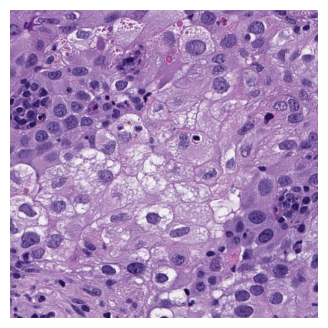

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 使用 single-patch notebook 里验证过的参数
PATCH_SIZE = 512
LEVEL = 0

# 先从中间取一个 reference patch（安全、不靠边）
wsi_w, wsi_h = slide.level_dimensions[LEVEL]
x = wsi_w // 2
y = wsi_h // 2

patch = slide.read_region(
    (x, y),
    level=LEVEL,
    size=(PATCH_SIZE, PATCH_SIZE)
).convert("RGB")

patch = np.array(patch)

print("Patch shape:", patch.shape)
print("Patch dtype:", patch.dtype)

plt.figure(figsize=(4, 4))
plt.imshow(patch)
plt.axis("off")
plt.show()


Step 5（前置）：Install StarDist (Colab only, once per runtime)

In [1]:
# Install StarDist and dependencies
!pip install -q stardist csbdeep tifffile


Step 5: Run StarDist on the reference patch


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Number of nuclei: 133


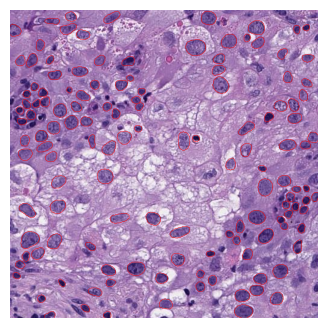

In [7]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

# Load pretrained StarDist model (same as successful single-patch runs)
model = StarDist2D.from_pretrained("2D_versatile_he")

# EXACT preprocessing as StarDist expects (RGB, channel-wise)
img = normalize(patch, axis=(0, 1))

# Run inference
labels, _ = model.predict_instances(img)

print("Number of nuclei:", int(labels.max()))

# Visualization
plt.figure(figsize=(4, 4))
plt.imshow(patch)
plt.contour(labels > 0, colors="red", linewidths=0.3)
plt.axis("off")
plt.show()


Step 6: Define batch patch extraction parameters


In [8]:
LEVEL = 0
PATCH_SIZE = (512, 512)
N_PATCHES = 100


Step 7: Randomly sample patch coordinates from the WSI


In [9]:
import random

wsi_w, wsi_h = slide.level_dimensions[LEVEL]

coords = []
for _ in range(N_PATCHES):
    x = random.randint(0, wsi_w - PATCH_SIZE[0])
    y = random.randint(0, wsi_h - PATCH_SIZE[1])
    coords.append((x, y))

print("Number of sampled coordinates:", len(coords))
coords[:5]


Number of sampled coordinates: 100


[(7567, 9339), (576, 1729), (17269, 5155), (41671, 14884), (38813, 12628)]

Step 8: Extract RGB patches from WSI using sampled coordinates


Total patches extracted: 100
Patch shape: (512, 512, 3)
Patch dtype: uint8


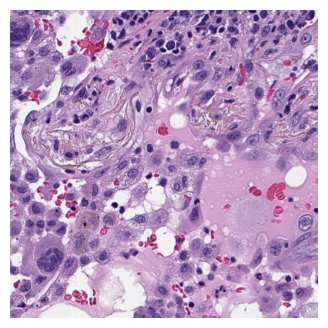

In [10]:
import numpy as np
import matplotlib.pyplot as plt

patches = []

for (x, y) in coords:
    patch = slide.read_region(
        (x, y),
        level=LEVEL,
        size=PATCH_SIZE
    ).convert("RGB")
    patch = np.array(patch)
    patches.append(patch)

print("Total patches extracted:", len(patches))
print("Patch shape:", patches[0].shape)
print("Patch dtype:", patches[0].dtype)

plt.figure(figsize=(4, 4))
plt.imshow(patches[0])
plt.axis("off")
plt.show()


Step 9: Run StarDist on 100 randomly sampled patches, excluding white-background patches,
using identical preprocessing as the validated single-patch run


In [12]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import numpy as np
import matplotlib.pyplot as plt


Step 9.1: Load pretrained StarDist model (same as single-patch validation)


In [13]:
model = StarDist2D.from_pretrained("2D_versatile_he")


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


Step 9.2: Define a conservative white-background filter based on grayscale intensity


In [14]:
def is_white_background(patch, frac_thresh=0.9, gray_thresh=230):
    """
    Identify nearly empty white-background patches.
    patch: RGB uint8 image (H, W, 3)
    """
    gray = patch.mean(axis=2)          # simple grayscale
    white_pixels = gray > gray_thresh  # very bright pixels
    return white_pixels.mean() > frac_thresh


Step 9.3: Run StarDist on non-white patches using identical preprocessing as Step 5


In [15]:
nuclei_counts = []
kept_patch_indices = []

for i, patch in enumerate(patches):  # patches from Step 8

    # --- Skip white background patches ---
    if is_white_background(patch):
        continue

    # --- EXACT SAME preprocessing as Step 5 ---
    # RGB, channel-wise normalization
    img = normalize(patch, axis=(0, 1))

    # --- StarDist inference ---
    labels, _ = model.predict_instances(img)
    n_nuclei = int(labels.max())

    nuclei_counts.append(n_nuclei)
    kept_patch_indices.append(i)

    # --- QC visualization (same as Step 5) ---
    plt.figure(figsize=(4, 4))
    plt.imshow(patch)
    plt.contour(labels > 0, colors="red", linewidths=0.3)
    plt.title(f"Patch {i} | nuclei = {n_nuclei}")
    plt.axis("off")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

Step 9.4: Summarize nuclei counts across filtered patches


In [16]:
print(f"Total patches sampled: {len(patches)}")
print(f"Patches kept after white-background filtering: {len(kept_patch_indices)}")
print("Nuclei per patch:", nuclei_counts)

if len(nuclei_counts) > 0:
    print("Mean nuclei per patch:", np.mean(nuclei_counts))
else:
    print("No valid tissue patches detected.")


Total patches sampled: 100
Patches kept after white-background filtering: 57
Nuclei per patch: [124, 152, 47, 39, 112, 66, 152, 39, 207, 57, 19, 132, 88, 154, 126, 73, 201, 123, 74, 93, 126, 30, 130, 67, 120, 104, 109, 60, 100, 174, 30, 76, 104, 140, 59, 161, 78, 27, 102, 51, 108, 79, 73, 119, 54, 158, 35, 123, 116, 222, 59, 58, 157, 145, 167, 151, 164]
Mean nuclei per patch: 103.75438596491227


Step 10: Export StarDist nucleus instance masks to GeoJSON (label-based)



In [18]:
from skimage import measure
from shapely.geometry import Polygon, mapping
import json
import os
import numpy as np

# Output directory
out_dir = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/geojson_100patch"
os.makedirs(out_dir, exist_ok=True)

geojson_paths = []

for idx, patch_idx in enumerate(kept_patch_indices):

    patch = patches[patch_idx]

    # === SAME preprocessing as Step 5 / Step 9 ===
    img = normalize(patch, axis=(0, 1))

    # === StarDist inference (INSTANCE LABELS) ===
    labels, _ = model.predict_instances(img)

    features = []

    # Extract polygon per nucleus from label mask
    for region in measure.regionprops(labels):

        if region.area < 10:  # tiny noise guard
            continue

        # region.coords → (row, col)
        coords = region.coords
        poly = Polygon([(c[1], c[0]) for c in coords]).convex_hull

        if not poly.is_valid or poly.area == 0:
            continue

        feature = {
            "type": "Feature",
            "properties": {
                "patch_index": int(patch_idx),
                "nucleus_id": int(region.label),
                "area": float(poly.area)
            },
            "geometry": mapping(poly)
        }
        features.append(feature)

    geojson = {
        "type": "FeatureCollection",
        "features": features
    }

    out_path = os.path.join(
        out_dir, f"patch_{patch_idx:03d}_nuclei.geojson"
    )

    with open(out_path, "w") as f:
        json.dump(geojson, f)

    geojson_paths.append(out_path)

print("GeoJSON files written:", len(geojson_paths))
print("Example file:", geojson_paths[0])


GeoJSON files written: 57
Example file: /content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/geojson_100patch/patch_000_nuclei.geojson


Step 11: Visualize StarDist instance masks with centroids (Python only)


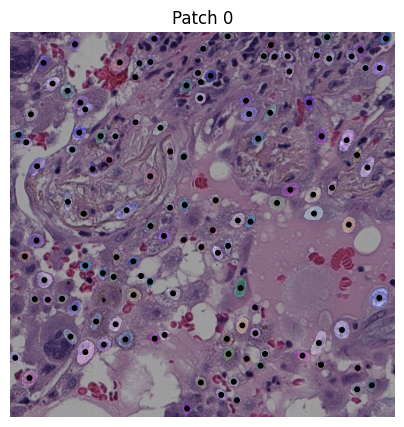

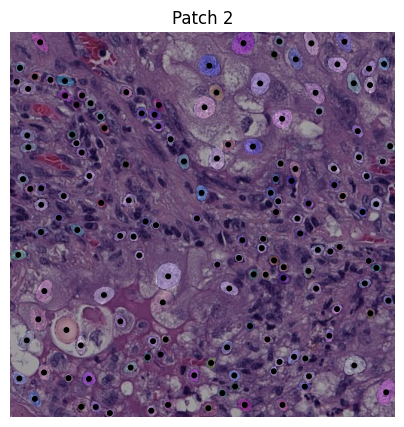

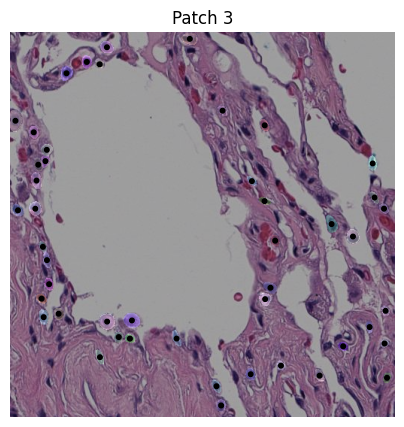

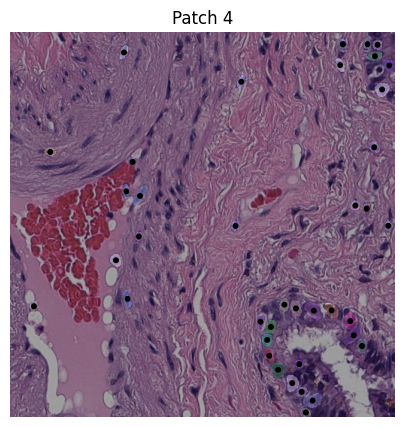

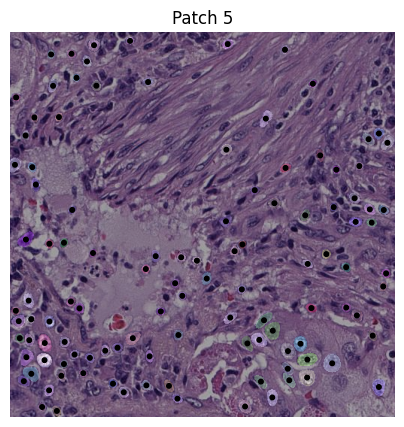

In [20]:
for example_patch_idx in kept_patch_indices[:5]:

    patch = patches[example_patch_idx]
    img = normalize(patch, axis=(0, 1))
    labels, _ = model.predict_instances(img)

    plt.figure(figsize=(5, 5))
    plt.imshow(patch)
    plt.imshow(labels, cmap=random_label_cmap(), alpha=0.35)

    for region in measure.regionprops(labels):
        y, x = region.centroid
        plt.gca().add_patch(
            Circle((x, y), radius=3, color="black", fill=True)
        )

    plt.title(f"Patch {example_patch_idx}")
    plt.axis("off")
    plt.show()


Step 12A: Extract nucleus-level features into a tabular DataFrame


In [21]:
import pandas as pd
from skimage import measure

rows = []

for patch_idx in kept_patch_indices:

    patch = patches[patch_idx]
    img = normalize(patch, axis=(0, 1))
    labels, _ = model.predict_instances(img)

    for region in measure.regionprops(labels):

        rows.append({
            "patch_index": patch_idx,
            "nucleus_id": region.label,
            "area": region.area,
            "eccentricity": region.eccentricity,
            "solidity": region.solidity,
            "centroid_x": region.centroid[1],
            "centroid_y": region.centroid[0]
        })

df_nuclei = pd.DataFrame(rows)

print(df_nuclei.head())
print("Total nuclei:", len(df_nuclei))



   patch_index  nucleus_id   area  eccentricity  solidity  centroid_x  \
0            0           1  549.0      0.590140  0.969965  490.699454   
1            0           2  218.0      0.564450  0.964602  288.087156   
2            0           3  180.0      0.534831  0.957447  266.405556   
3            0           4  244.0      0.191386  0.964427  461.073770   
4            0           5  158.0      0.468809  0.946108   49.987342   

   centroid_y  
0  353.209472  
1  407.784404  
2   57.833333  
3  474.758197  
4  355.518987  
Total nuclei: 5914


Step 12B: Export nuclei polygons + centroids together into GeoJSON


In [22]:
from shapely.geometry import Polygon, Point, mapping
import json
import os

out_geojson = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/geojson_nuclei_with_centroid"
os.makedirs(out_geojson, exist_ok=True)

for patch_idx in kept_patch_indices:

    patch = patches[patch_idx]
    img = normalize(patch, axis=(0, 1))
    labels, _ = model.predict_instances(img)

    features = []

    for region in measure.regionprops(labels):

        coords = region.coords
        poly = Polygon([(c[1], c[0]) for c in coords]).convex_hull
        if not poly.is_valid or poly.area == 0:
            continue

        cy, cx = region.centroid

        feature = {
            "type": "Feature",
            "properties": {
                "patch_index": int(patch_idx),
                "nucleus_id": int(region.label),
                "area": float(region.area),
                "eccentricity": float(region.eccentricity),
                "solidity": float(region.solidity),
                "centroid_x": float(cx),
                "centroid_y": float(cy)
            },
            "geometry": {
                "type": "GeometryCollection",
                "geometries": [
                    mapping(poly),
                    mapping(Point(cx, cy))
                ]
            }
        }

        features.append(feature)

    geojson = {
        "type": "FeatureCollection",
        "features": features
    }

    out_path = os.path.join(
        out_geojson, f"patch_{patch_idx:03d}_nuclei_with_centroid.geojson"
    )

    with open(out_path, "w") as f:
        json.dump(geojson, f)

print("GeoJSON with centroid written for", len(kept_patch_indices), "patches")


GeoJSON with centroid written for 57 patches


Step 12C (fixed): Map nucleus centroids back to WSI level-0 coordinates (index-safe)


In [24]:
LEVEL = 0
PATCH_SIZE = 512

records = []

for patch_idx in kept_patch_indices:

    # ✅ 用 patch_idx 正确索引坐标
    x, y = coords[patch_idx]

    patch = patches[patch_idx]
    img = normalize(patch, axis=(0, 1))
    labels, _ = model.predict_instances(img)

    for region in measure.regionprops(labels):

        cy, cx = region.centroid

        wsi_x = x + cx
        wsi_y = y + cy

        records.append({
            "patch_index": patch_idx,
            "nucleus_id": region.label,
            "wsi_x": wsi_x,
            "wsi_y": wsi_y
        })

df_wsi_centroids = pd.DataFrame(records)

print("Total nuclei mapped:", len(df_wsi_centroids))
print("Unique patches:", df_wsi_centroids['patch_index'].nunique())
print(df_wsi_centroids.head())


Total nuclei mapped: 5914
Unique patches: 57
   patch_index  nucleus_id       wsi_x       wsi_y
0            0           1  630.699454  749.209472
1            0           2  428.087156  803.784404
2            0           3  406.405556  453.833333
3            0           4  601.073770  870.758197
4            0           5  189.987342  751.518987
